<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

Establish a basic class of hot water cylinder that can be used to model a mixed hot water cylinder. The model is based on the following assumptions:

$C_v\rho V \frac{dT(t)}{dt} = C_v\rho F(t)[T_{in} - T(t)]+Q(t)-UA\text{[T(t)-}T_{atm}]$

In [1]:
#| echo: false
#| output: asis
show_doc(HWC)

---

[source](https://github.com/CJP123/cylinder/blob/main/cylinder/hwc.py#L19){target="_blank" style="float:right; font-size:smaller"}

### HWC

>      HWC (element=3, T_set=65, T_deadband=2, radius=0.25, height=1, unit=None,
>           bedrooms=None, id=None)

Simple mixed model for a hot water cylinder

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| element | int | 3 | Watts |
| T_set | int | 65 | °C |
| T_deadband | int | 2 | °C |
| radius | float | 0.25 | Meters |
| height | int | 1 | Meters |
| unit | NoneType | None | Unit of measure for volume |
| bedrooms | NoneType | None |  |
| id | NoneType | None |  |

Provide a mechanisim to set the thermostat state based on the model temperature

Update the model temperature based on the thermostat state / flow / heat loss

$T_{i+1} = T_i + \frac{F_i}{V}[T_{in} - T_i]\Delta{t}+\frac{Q_i}{C_v\rho V}\Delta{t}-\frac{UA}{C_v\rho V}[T_i-T_{atm}]\Delta{t}$

Provide some initialisation functions to set the model up with some default values

In [2]:
#| echo: false
#| output: asis
show_doc(HWC.reset)

---

[source](https://github.com/CJP123/cylinder/blob/main/cylinder/hwc.py#L79){target="_blank" style="float:right; font-size:smaller"}

### HWC.reset

>      HWC.reset ()

In [ ]:
df = (pd.DataFrame(load_demand(path = Path('../data/drawprofiles'),bed=5,unit=4)))
df.columns=["flow"]
df = df.merge(load_power(path = Path('../data')), how='left', left_index=True, right_index=True)
df.head()

,flow,price,price_kw,date,week,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,7.920,0.007920,2020-01-01,1,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,0.0,8.526,0.008526,2020-01-01,1,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,0.0,9.132,0.009132,2020-01-01,1,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,0.0,9.738,0.009738,2020-01-01,1,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,0.0,10.344,0.010344,2020-01-01,1,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645


In [ ]:
hwc = HWC(T_set=55, T_deadband=2, element=3000, radius=.2, height=1.5)
results = []
for index, row in df.loc['2020-01-01'].iterrows():
  raw_flow = 0
  hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold)
  hwc._thermostat()
  hwc.T = hwc._update_temperatures(action=0)
  results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
results = pd.DataFrame(results, columns=['time','temperature','thermostat','flow','cost']).set_index('time')

In [ ]:
print(f'The HWC volume is {int(hwc.volume*1000)} liters')
print(f'The HWC surface area is {hwc.surface_area:.2f} m2')
print(f'One day standing heat losses  : {4.128*.188*(results.temperature.max()-results.temperature.min()):.2f} kWh')

The HWC volume is 188 liters
The HWC surface area is 2.14 m2
One day standing heat losses  : 1.42 kWh


The standing heat loss for a tank should be in the order of 1.7 kWh / day for a tank at 55 degrees.

Guidance for loss is 3 W/K for a tank at 55 degrees

https://sustainableengineering.co.nz/portfolio-item/dhw-tanks-w-k-from-kwh-day/

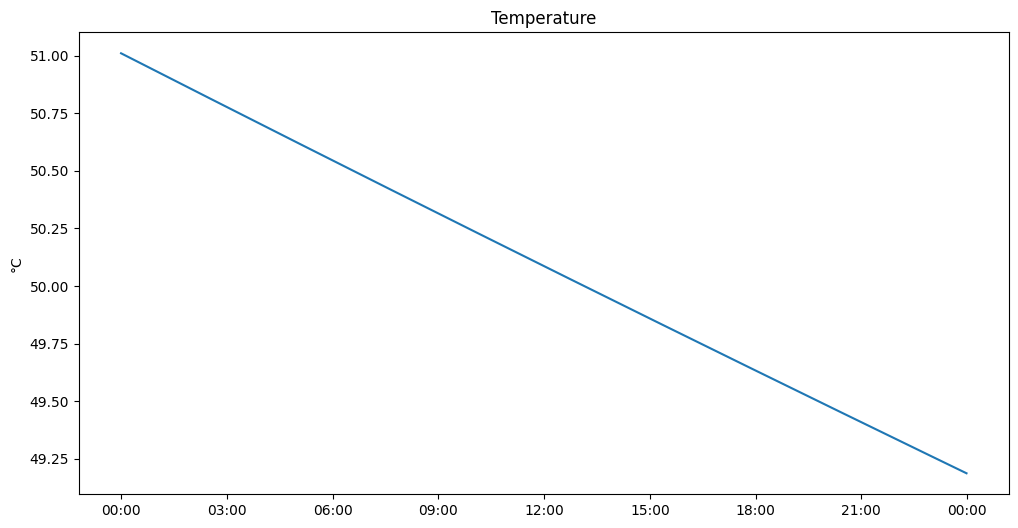

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
ax.plot(results.temperature)
ax.set_ylabel('°C')
ax.set_title('Temperature')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))